In [1]:
### Load relevant packages

import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import os

# This statement allow to display plot without asking to 
%matplotlib inline

# always make it pretty 
plt.style.use('ggplot')

In [2]:
admis = pd.read_csv('cleaned_ADMISSIONS.csv')
icd = pd.read_csv('cleaned_D_ICD_DIAGNOSES.csv')
expire = pd.read_csv('cleaned_drug_atc_expire.csv')
icu = pd.read_csv('cleaned_ICUSTAYS.csv')
pat = pd.read_csv('cleaned_PATIENTS.csv')
expire = pd.read_csv('cleaned_drug_expire.csv')
month = pd.read_csv('cleaned_monthly_mortality.csv')
pre = pd.read_csv('cleaned_PRESCRIPTIONS.csv',low_memory=False)

In [3]:
admin = admis['SUBJECT_ID'].isin(np.unique(list(icu['SUBJECT_ID'])))

In [4]:
admin = admis[admin]
dead = admin.dropna(subset=["DEATHTIME"])
dead_reset = dead.reset_index(drop=True)
dead_reset['month_dead'] = np.array([dead_reset['DEATHTIME'][i][5:7] for i in range(len(dead_reset))])

In [5]:
import datetime
from datetime import datetime
dead_reset['time_in_hospital'] = np.array([datetime.strptime(dead_reset['DEATHTIME'][i][:10], '%Y-%m-%d')  - datetime.strptime(dead_reset['ADMITTIME'][i][:10], '%Y-%m-%d') for i in range(len(dead_reset))]) 
dead_reset['time_in_hospital_days'] = [dead_reset['time_in_hospital'][i].days for i in range(len(dead_reset))]
dead_reset['death_age'] = np.array([datetime.strptime(dead_reset['DEATHTIME'][i][:10], '%Y-%m-%d')  - datetime.strptime(dead_reset['DOB'][i], '%Y-%m-%d') for i in range(len(dead_reset))])
dead_reset['death_age_days'] = [dead_reset['death_age'][i].days for i in range(len(dead_reset))]
dead_reset['month_factor'], _ = pd.factorize(dead_reset['month_dead'], sort=True)

In [6]:
onehotmonth = pd.get_dummies(dead_reset['month_dead'], sparse=True).drop(labels='12', axis=1)
for i in onehotmonth.columns:
    onehotmonth.rename({i: 'DeathMonth' + i},axis=1,inplace=True)
dead_reset['month_dead_cat'] = dead_reset['month_dead'].astype("category")

In [7]:
df4 = dead_reset.filter(regex='ADMISSION_TYPE')
for i in df4.columns:
    df4[i].replace(False, 0, inplace=True)
    df4[i].replace(True, 1, inplace=True)
df4
#Reference category: URGENT
df4comp = df4.iloc[:, :-1]
df4comp

C:\Users\Solomon\AppData\Local\Temp\ipykernel_17936\3674818092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4[i].replace(False, 0, inplace=True)
C:\Users\Solomon\AppData\Local\Temp\ipykernel_17936\3674818092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4[i].replace(True, 1, inplace=True)


,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
5847,1,0
5848,1,0
5849,1,0
5850,1,0


In [8]:
diaglist = [str(element) for element in list(dead_reset['DIAGNOSIS'].values)]
isFAILURE = []
for i in range(len(diaglist)):
    if 'FAILURE' in diaglist[i]:
        isFAILURE.append(1)
    else:
        isFAILURE.append(0)
from array import array
df5 = pd.DataFrame(isFAILURE)

isBLEED = []
for i in range(len(diaglist)):
    if 'BLEED' in diaglist[i]:
        isBLEED.append(1)
    else:
        isBLEED.append(0)
from array import array
df6 = pd.DataFrame(isBLEED)

isCARDIAC = []
for i in range(len(diaglist)):
    if 'CARDIAC' in diaglist[i]:
        isCARDIAC.append(1)
    else:
        isCARDIAC.append(0)
from array import array
df7 = pd.DataFrame(isCARDIAC)

isRESPIRAT = []
for i in range(len(diaglist)):
    if 'RESPIRAT' in diaglist[i]:
        isRESPIRAT.append(1)
    elif 'BREATH' in diaglist[i]:
        isRESPIRAT.append(1)
    else:
        isRESPIRAT.append(0)
from array import array
df8 = pd.DataFrame(isRESPIRAT)

isSEPSIS = []
for i in range(len(diaglist)):
    if 'SEPSIS' in diaglist[i]:
        isSEPSIS.append(1)
    else:
        isSEPSIS.append(0)
from array import array
df9 = pd.DataFrame(isSEPSIS)

isSTROKE = []
for i in range(len(diaglist)):
    if 'STROKE' in diaglist[i]:
        isSTROKE.append(1)
    else:
        isSTROKE.append(0)
from array import array
df10 = pd.DataFrame(isSTROKE)

isPNEUMONIA = []
for i in range(len(diaglist)):
    if 'PNEUMONIA' in diaglist[i]:
        isPNEUMONIA.append(1)
    else:
        isPNEUMONIA.append(0)
from array import array
df11 = pd.DataFrame(isPNEUMONIA)

In [9]:
diseasedf = pd.concat([df5,df6,df7,df8,df9,df10,df11],axis=1)
diseasedf.columns = ['Failure','Bleed','Cardiac','Respiratory','Sepsis','Stroke','Pneumonia']

In [10]:
finaldf1 = pd.concat([dead_reset['ADMISSION_LOCATION'],dead_reset['time_in_hospital_days'],df4,diseasedf,dead_reset['month_dead_cat']],axis=1)

In [11]:
onehotlocation = pd.get_dummies(dead_reset['ADMISSION_LOCATION'], sparse=True).drop(labels='** INFO NOT AVAILABLE **', axis=1)
#Reference: INFO NOT AVAILABLE
onehotlocation

,CLINIC REFERRAL/PREMATURE,EMERGENCY ROOM ADMIT,HMO REFERRAL/SICK,PHYS REFERRAL/NORMAL DELI,TRANSFER FROM HOSP/EXTRAM,TRANSFER FROM OTHER HEALT,TRANSFER FROM SKILLED NUR
0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
5847,1,0,0,0,0,0,0
5848,1,0,0,0,0,0,0
5849,1,0,0,0,0,0,0
5850,0,1,0,0,0,0,0


In [12]:
finaldf1 = pd.concat([onehotlocation,dead_reset['time_in_hospital_days'],df4,diseasedf,dead_reset['month_dead_cat']],axis=1)

In [13]:
from sklearn.model_selection import train_test_split
X = pd.get_dummies(finaldf1.drop(columns = 'month_dead_cat'))
y = finaldf1['month_dead_cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from collections import Counter
input =  list(finaldf1['month_dead_cat'])
Counter( input )

Counter({'08': 500,
         '01': 517,
         '02': 468,
         '12': 527,
         '04': 532,
         '05': 463,
         '10': 497,
         '09': 492,
         '11': 456,
         '07': 458,
         '03': 511,
         '06': 431})

0.0812991452991453
0.06752136752136752
0.10256410256410256


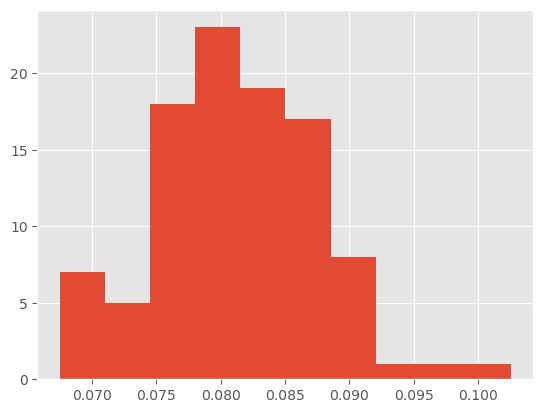

In [15]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import random
sampler = list(range(len(admin)))
random.shuffle(sampler)

modelaccuracy = []

for i in range(100):
    import random
    sampler = list(range(len(finaldf1)))
    random.shuffle(sampler)
    training_data = sampler[0:round(0.8*len(finaldf1))]
    testing_data = sampler[round(0.8*len(finaldf1)):(len(finaldf1)+1)]
    training_df = finaldf1.drop(columns = 'month_dead_cat').iloc[training_data,:]
    testing_df = finaldf1.drop(columns = 'month_dead_cat').iloc[testing_data,:]
    training_y = finaldf1['month_dead_cat'].iloc[training_data]
    testing_y = finaldf1['month_dead_cat'].iloc[testing_data]
    model = LogisticRegression()
    model.fit(training_df,training_y)
    modelaccuracy.append(model.score(testing_df,testing_y))
print(np.mean(modelaccuracy))
print(min(modelaccuracy))
print(max(modelaccuracy))

import matplotlib.pyplot as plt
plt.hist(modelaccuracy)
plt.show()

As seen, our model is terrible at predicting which month an individual dies.

In [16]:
religion = admin.filter(regex='RELIGION')
for i in religion.columns:
    religion[i].replace(False, 0, inplace=True)
    religion[i].replace(True, 1, inplace=True)
#Reference category: UNOBTAINABLE RELIGION
religionfinal = religion.iloc[:, :-1]
religionfinal

ethnicity = admin.filter(regex='ETHNICITY')
for i in ethnicity.columns:
    ethnicity[i].replace(False, 0, inplace=True)
    ethnicity[i].replace(True, 1, inplace=True)
#Reference category: Russian Ethnicity
ethnicityfinal = ethnicity.iloc[:, :-1]
ethnicityfinal

language = admin.filter(regex='LANGUAGE')
for i in language.columns:
    language[i].replace(False, 0, inplace=True)
    language[i].replace(True, 1, inplace=True)
#Reference category: Vietnamese language
languagefinal = language.iloc[:, :-1]
language

,LANGUAGE_* FU,LANGUAGE_** T,LANGUAGE_**SH,LANGUAGE_**TO,LANGUAGE_*AMH,LANGUAGE_*ARA,LANGUAGE_*ARM,LANGUAGE_*BEN,LANGUAGE_*BOS,LANGUAGE_*BUL,...,LANGUAGE_PTUN,LANGUAGE_RUSS,LANGUAGE_SERB,LANGUAGE_SOMA,LANGUAGE_SPAN,LANGUAGE_TAGA,LANGUAGE_THAI,LANGUAGE_TURK,LANGUAGE_URDU,LANGUAGE_VIET
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58973,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
indq3 = pd.concat([religion,ethnicity,language],axis=1)

In [18]:
from sklearn import svm

In [19]:
test = admin[admin['DEATHTIME'].isnull()]

test['DEATH'] = 0

test

dead['DEATH'] = 1

q3df = pd.concat([test,dead])

0.9003122878479293
0.8845892735913102
0.9205702647657841


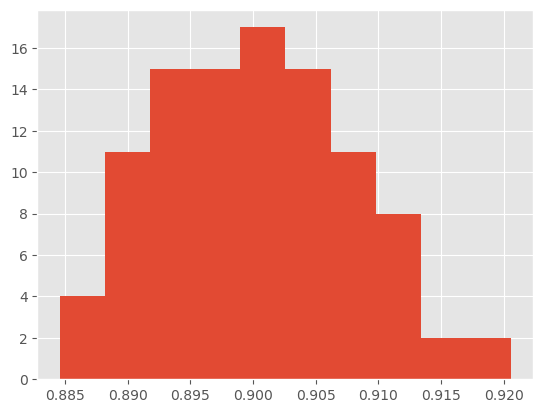

In [20]:
import random
sampler = list(range(len(admin)))
random.shuffle(sampler)

model2accuracy = []

for i in range(100):
    import random
    sampler = list(range(len(q3df)))
    random.shuffle(sampler)
    training_data = sampler[0:round(0.1*len(q3df))]
    testing_data = sampler[round(0.1*len(q3df)):round(0.125*len(q3df))]
    training_df = indq3.iloc[training_data,:]
    testing_df = indq3.iloc[testing_data,:]
    training_y = q3df['DEATH'].iloc[training_data]
    testing_y = q3df['DEATH'].iloc[testing_data]
    model2 = svm.SVC(C=1,kernel='linear')
    model2.fit(training_df,training_y)
    model2accuracy.append(model2.score(testing_df,testing_y))


print(np.mean(model2accuracy))
print(min(model2accuracy))
print(max(model2accuracy))

import matplotlib.pyplot as plt
plt.hist(model2accuracy)
plt.show()

In [21]:
deadicu = q3df[q3df['DEATH']==0]
aliveicu = q3df[q3df['DEATH']==1]

In [22]:
religiondead = deadicu.filter(regex='RELIGION')

In [23]:
religiondead = deadicu.filter(regex='RELIGION')
religionalive = aliveicu.filter(regex='RELIGION')
for i in religiondead.columns:
    deadrel = len(religiondead[religiondead[i]==True])
    aliverel = len(religionalive[religionalive[i]==True])
    avgrel = round((deadrel/(deadrel + aliverel))*100,1)
    print(f"There are a total of {aliverel+deadrel} individuals in {i}, and {avgrel}% have died")

There are a total of 28 individuals in RELIGION_BAPTIST, and 71.4% have died
There are a total of 267 individuals in RELIGION_BUDDHIST, and 92.9% have died
There are a total of 20588 individuals in RELIGION_CATHOLIC, and 90.7% have died
There are a total of 429 individuals in RELIGION_CHRISTIAN SCIENTIST, and 92.5% have died
There are a total of 774 individuals in RELIGION_EPISCOPALIAN, and 91.3% have died
There are a total of 458 individuals in RELIGION_GREEK ORTHODOX, and 91.7% have died
There are a total of 16 individuals in RELIGION_HEBREW, and 75.0% have died
There are a total of 113 individuals in RELIGION_HINDU, and 92.0% have died
There are a total of 139 individuals in RELIGION_JEHOVAH'S WITNESS, and 87.8% have died
There are a total of 5308 individuals in RELIGION_JEWISH, and 87.4% have died
There are a total of 1 individuals in RELIGION_LUTHERAN, and 100.0% have died
There are a total of 7 individuals in RELIGION_METHODIST, and 85.7% have died
There are a total of 224 indivi

In [24]:
ethnicitydead = deadicu.filter(regex='ETHNICITY')
ethnicityalive = aliveicu.filter(regex='ETHNICITY')
for i in ethnicitydead.columns:
    deadeth = len(ethnicitydead[ethnicitydead[i]==True])
    aliveeth = len(ethnicityalive[ethnicityalive[i]==True])
    avgeth = round((deadeth/(deadeth + aliveeth))*100,1)
    print(f"There are a total of {aliveeth+deadeth} individuals in {i}, and {avgeth}% have died")

There are a total of 3 individuals in ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE, and 66.7% have died
There are a total of 1509 individuals in ETHNICITY_ASIAN, and 93.0% have died
There are a total of 85 individuals in ETHNICITY_ASIAN - ASIAN INDIAN, and 96.5% have died
There are a total of 17 individuals in ETHNICITY_ASIAN - CAMBODIAN, and 76.5% have died
There are a total of 276 individuals in ETHNICITY_ASIAN - CHINESE, and 90.2% have died
There are a total of 25 individuals in ETHNICITY_ASIAN - FILIPINO, and 92.0% have died
There are a total of 7 individuals in ETHNICITY_ASIAN - JAPANESE, and 71.4% have died
There are a total of 13 individuals in ETHNICITY_ASIAN - KOREAN, and 92.3% have died
There are a total of 17 individuals in ETHNICITY_ASIAN - OTHER, and 88.2% have died
There are a total of 4 individuals in ETHNICITY_ASIAN - THAI, and 100.0% have died
There are a total of 53 individuals in ETHNICITY_ASIAN - VIETNAMESE, and 88.7% have died
There are a tota

In [25]:
languagedead = deadicu.filter(regex='LANGUAGE')
languagealive = aliveicu.filter(regex='LANGUAGE')
for i in languagedead.columns:
    deadlang = len(languagedead[languagedead[i]==True])
    alivelang = len(languagealive[languagealive[i]==True])
    avglang = round((deadlang/(deadlang + alivelang))*100,1)
    print(f"There are a total of {alivelang+deadlang} individuals in {i}, and {avglang}% have died")

There are a total of 1 individuals in LANGUAGE_* FU, and 100.0% have died
There are a total of 1 individuals in LANGUAGE_** T, and 100.0% have died
There are a total of 2 individuals in LANGUAGE_**SH, and 100.0% have died
There are a total of 3 individuals in LANGUAGE_**TO, and 33.3% have died
There are a total of 2 individuals in LANGUAGE_*AMH, and 50.0% have died
There are a total of 1 individuals in LANGUAGE_*ARA, and 100.0% have died
There are a total of 9 individuals in LANGUAGE_*ARM, and 55.6% have died
There are a total of 7 individuals in LANGUAGE_*BEN, and 85.7% have died
There are a total of 1 individuals in LANGUAGE_*BOS, and 100.0% have died
There are a total of 5 individuals in LANGUAGE_*BUL, and 100.0% have died
There are a total of 4 individuals in LANGUAGE_*BUR, and 75.0% have died
There are a total of 2 individuals in LANGUAGE_*CAN, and 100.0% have died
There are a total of 4 individuals in LANGUAGE_*CDI, and 75.0% have died
There are a total of 7 individuals in LANGUA